In [1]:
import numpy as np
import pickle
from tqdm import tqdm
from pathlib import Path
from scipy.spatial import kdtree

import rose

In [2]:
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
from matplotlib import rcParams
from rose.training import multiple_formatter

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rcParams[
    "text.latex.preamble"
] = r"\usepackage{amssymb} \usepackage{amsmath}"
plt.rc("text", usetex=True)

rcParams["legend.fontsize"] = 12
rcParams["font.size"] = 12
rcParams["font.weight"] = "normal"
rcParams["xtick.labelsize"] = 12.0
rcParams["ytick.labelsize"] = 12.0
rcParams["lines.linewidth"] = 2.0
rcParams["xtick.major.pad"] = "10"
rcParams["ytick.major.pad"] = "10"
rcParams["image.cmap"] = "BuPu"

## Generate parameters

In [3]:
from rose.koning_delaroche import KD_simple, KD_simple_so, KDGlobal, Projectile
cgmf_ebin = np.linspace(0.08, 10, 200)
ebounds = np.array([cgmf_ebin[0], cgmf_ebin[-1]])
E_GRID_SIZE = cgmf_ebin.size
E_GRID = cgmf_ebin
isotopes = [
    (56,134),
    (56,135),
    (56,136),
    (56,137),
    (48,110),
    (48,111),
    (48,112),
    (48,113),
    (48,114),
    (48,116),
    (48,106),
    (48,108),
    (55,133),
    (53,127),
    (49,115),
    (57,139),
    (42,92),
    (42,94),
    (42,96),
    (42,98),
    (42,100),
    (42,95),
    (41,93),
    (45,103),
    (50,120),
    (50,118),
    (50,122),
    (50,124),
    (50,116),
    (50,114),
    (50,115),
    (50,117),
    (50,112),
    (50,119),
    (43,99),
    (52,122),
    (52,124),
    (52,125),
    (52,126),
    (52,128),
    (52,130),
    (40,90),
]
if False:
    NUM_ISOTOPES = len(isotopes)
    omp = rose.koning_delaroche.KDGlobal(Projectile.neutron)
    (mu, Ecom, k, eta, R_C), parameters = omp.get_params(1, 1, 0.1)
    N_PARAMS = len(parameters) + 2
    N_PARAMS
    params = np.zeros((NUM_ISOTOPES, E_GRID_SIZE, N_PARAMS), dtype=np.double)
    for i, (Z,A) in tqdm(enumerate(isotopes), total=NUM_ISOTOPES):
        for j, e in enumerate(E_GRID):
            (mu, Ecom, _, _, _), parameters = omp.get_params(A, Z, E_com=e)
            params[i,j,:] = np.array([Ecom, mu, *parameters])
    np.save("./kd_ff_params.npy", params)
else:
    params =  np.load("kd_ff_params.npy")

In [4]:
params.shape

(42, 200, 17)

In [5]:
lower_bound = np.min(params, axis=(0, 1))
lower_bound[0] = 1.0e-1
upper_bound = np.max(params, axis=(0, 1))
bounds = np.vstack([lower_bound, upper_bound]).T
frozen_params = bounds[:,1] == bounds[:,0]
unfrozen_mask = np.logical_not(frozen_params)
param_labels  =np.asarray(
    [
        r"$E$",
        r"$\mu$",
        r"$v_v$",
        r"$r_v$",
        r"$a_v$",
        r"$v_w$",
        r"$r_{w}$",
        r"$a_{w}$",
        r"$v_d$",
        r"$r_{d}$",
        r"$a_d$",
        r"$v_{so}$", 
        r"$r_{so}$",
        r"$a_{so}$",
        r"$w_{so}$",
        r"$r_{wso}$",
        r"$a_{wso}$",
    ]

)

In [6]:
bounds

array([[ 1.00000000e-01,  1.00000000e+01],
       [ 9.29216495e+02,  9.42609993e+02],
       [ 4.57399881e+01,  5.18465025e+01],
       [ 5.43790365e+00,  6.34893430e+00],
       [ 6.57130700e-01,  6.64417000e-01],
       [ 1.18756180e-01,  7.12183622e-01],
       [ 5.43790365e+00,  6.34893430e+00],
       [ 6.57130700e-01,  6.64417000e-01],
       [ 3.43593023e+00,  7.05855048e+00],
       [ 5.69752236e+00,  6.52845801e+00],
       [ 5.21581600e-01,  5.29696000e-01],
       [ 5.74114195e+00,  6.14714156e+00],
       [ 4.66525719e+00,  5.49349228e+00],
       [ 5.90000000e-01,  5.90000000e-01],
       [-4.26606326e-02, -7.13238921e-03],
       [ 4.66525719e+00,  5.49349228e+00],
       [ 5.90000000e-01,  5.90000000e-01]])

## Generate training data and build ASQ

In [7]:
from rose.training import latin_hypercube_sample
if False:
    n_train = 500
    n_train_log = 700
    n_test = 1000

    train = latin_hypercube_sample(n_train, bounds, seed=137)

    log_energy_bounds = bounds.copy()
    log_energy_bounds[0,:] = np.log(bounds[0,:])
    log_train = latin_hypercube_sample(n_train_log, log_energy_bounds, seed=139)
    log_train[:,0] = np.exp(log_train[:,0])

    train = np.concatenate([ train, log_train])
    rng = np.random.default_rng(12345)
    rng.shuffle(train, axis=0)
    np.save("train_uq.npy", train)
else:
    train = np.load("train_uq.npy")

n_test = train.shape[0]
test = latin_hypercube_sample(n_test, bounds, seed=111)

(array([413., 148., 110.,  92.,  83.,  77.,  73.,  70.,  67.,  67.]),
 array([0.10063593, 1.08889807, 2.07716021, 3.06542235, 4.05368449,
        5.04194662, 6.03020876, 7.0184709 , 8.00673304, 8.99499517,
        9.98325731]),
 <BarContainer object of 10 artists>)

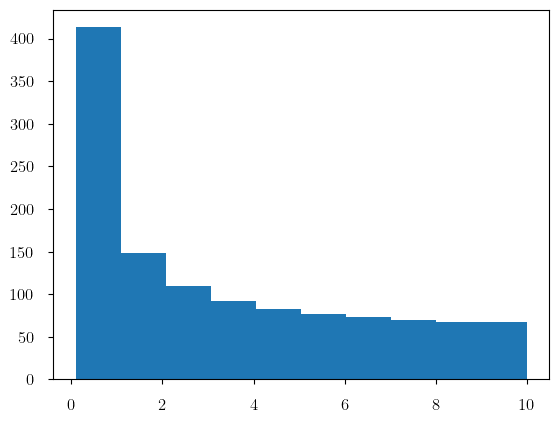

In [8]:
plt.hist([train[:,0]])

In [9]:
bounds

array([[ 1.00000000e-01,  1.00000000e+01],
       [ 9.29216495e+02,  9.42609993e+02],
       [ 4.57399881e+01,  5.18465025e+01],
       [ 5.43790365e+00,  6.34893430e+00],
       [ 6.57130700e-01,  6.64417000e-01],
       [ 1.18756180e-01,  7.12183622e-01],
       [ 5.43790365e+00,  6.34893430e+00],
       [ 6.57130700e-01,  6.64417000e-01],
       [ 3.43593023e+00,  7.05855048e+00],
       [ 5.69752236e+00,  6.52845801e+00],
       [ 5.21581600e-01,  5.29696000e-01],
       [ 5.74114195e+00,  6.14714156e+00],
       [ 4.66525719e+00,  5.49349228e+00],
       [ 5.90000000e-01,  5.90000000e-01],
       [-4.26606326e-02, -7.13238921e-03],
       [ 4.66525719e+00,  5.49349228e+00],
       [ 5.90000000e-01,  5.90000000e-01]])

In [10]:
# use log(E) space
scaleE = 1.0
def forward_pspace_transform(sample):
    return np.hstack([ np.log(sample[0]/scaleE), sample[1:]])

def backward_pspace_transform(sample):
    return np.hstack([np.exp(sample[0])*scaleE, sample[1:]])

In [11]:
l_max=10
angles = np.linspace(0, np.pi, 3)
s_mesh = np.linspace(1e-2, 5* np.pi, 1300)
domain = np.array([s_mesh[0], s_mesh[-1]])
s_0 = 4.5 * np.pi

In [12]:
interactions = rose.koning_delaroche.EnergizedKoningDelaroche(
    training_info=bounds,
    n_basis=15,
    l_max=l_max,
    n_train=10,
)
sae = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    base_solver=rose.SchroedingerEquation.make_base_solver(
        s_0=s_0,
        domain=domain,
    ),
    interaction_space=interactions,
    angles=angles,
    s_mesh=s_mesh,
)

/home/beykyle/rose/src/rose/scattering_amplitude_emulator.py:354: RuntimeWarning: invalid value encountered in divide
  self.rutherford = 0.0 / (np.sin(self.angles / 2) ** 4)


In [13]:
%%time
asq = rose.ActiveSubspaceQuilt(
    interactions,
    sae,
    s_mesh,
    s_0,
    bounds,
    train,
    forward_pspace_transform,
    backward_pspace_transform,
    frozen_params,
    30,
    0.2,
    threads=8,
       hf_soln_file="hf_solns_uq.npy",
)
#np.save("hf_solns_uq.npy", asq.hf_solns)

/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (


Calculating interaction terms at 1200 samples...
Reading training wavefunctions from hf_solns_uq.npy ...
Discovering active subspace from 1200 samples...


/home/beykyle/rose/src/rose/active_subspace.py:390: RuntimeWarning: invalid value encountered in divide
  np.trapz(
/home/beykyle/rose/src/rose/active_subspace.py:403: RuntimeWarning: invalid value encountered in divide
  np.trapz(


Constructing RBMs from neighborhoods around 241 sampled tangent points...
241 tangent points chosen using weighted method. Building neighborhoods...


100%|██████████| 241/241 [21:35<00:00,  5.38s/it]

CPU times: user 1h 16min 44s, sys: 1h 14min 9s, total: 2h 30min 53s
Wall time: 22min 4s


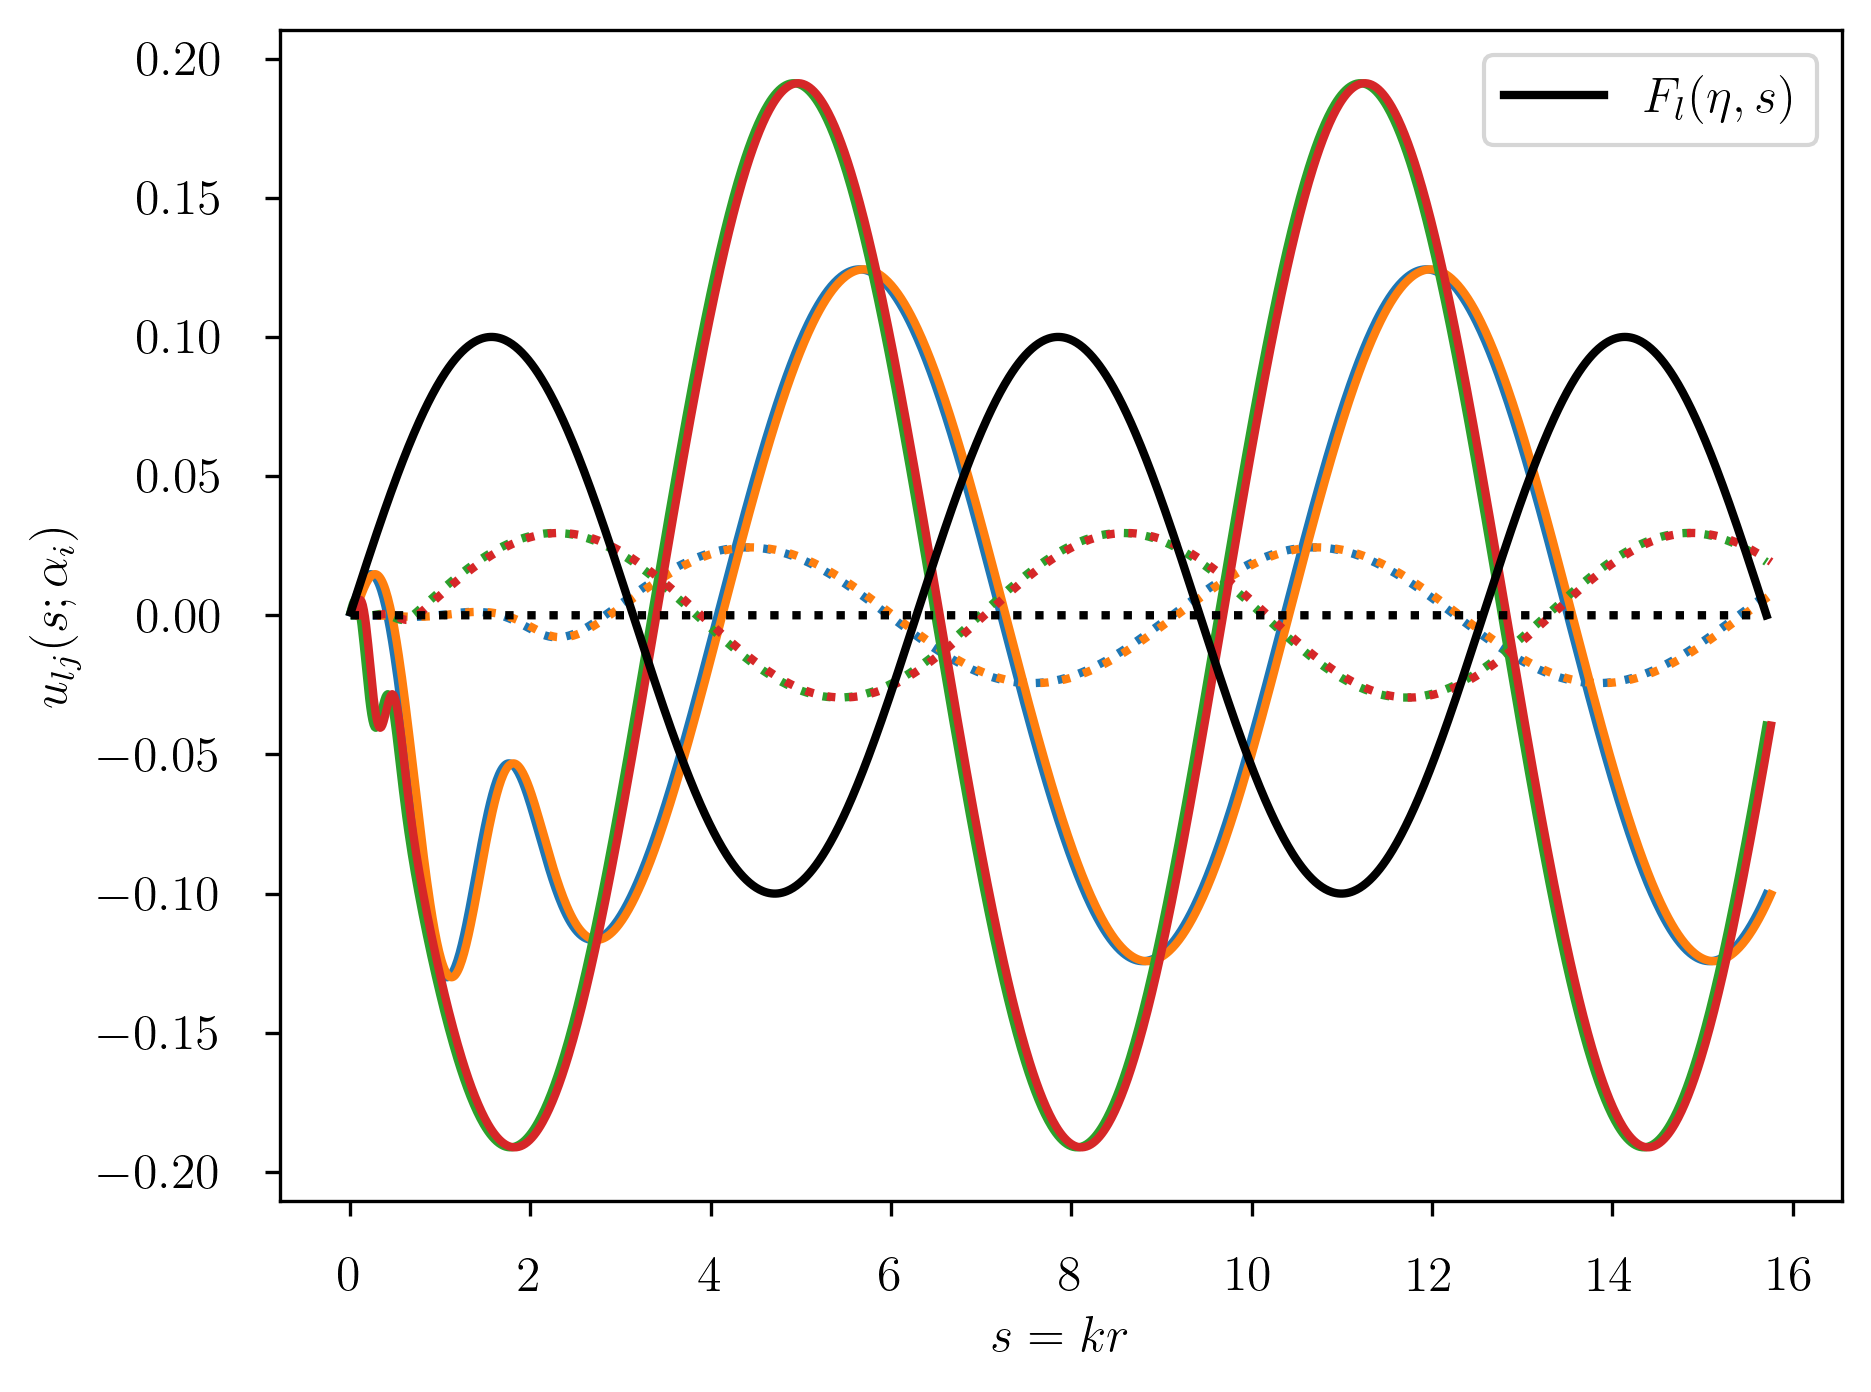

In [14]:
#TODO ensure hf_solns and interaction terms are consistent w/ previous training runs
f = plt.figure(facecolor="white", dpi=300)
l = 0
s_mesh = asq.s_mesh
for i in range(0,2):
    sample = train[i,:]
    solns = sae.exact_wave_functions(sample)
    z = asq.hf_solns[i,l,:]
    y = solns[l][0]
    y /= np.trapz(np.absolute(y), s_mesh)
    y -= asq.free_solns[l,:]
    p = plt.plot(s_mesh, y.real)[0]
    plt.plot(
        s_mesh,
        y.imag,
        ":",
        color=p.get_color(),
    )
    p = plt.plot(s_mesh+0.05, z.real)[0]
    plt.plot(
        s_mesh+0.05,
        z.imag,
        ":",
        color=p.get_color(),
    )


plt.plot(s_mesh, asq.free_solns[l,:].real, "k", label=r"$F_l(\eta, s)$")
plt.plot(s_mesh, asq.free_solns[l,:].imag, ":k")

plt.xlabel(r"$s = kr$")
plt.ylabel(r"$u_{lj}(s; \alpha_i)$")
plt.legend()
plt.tight_layout()

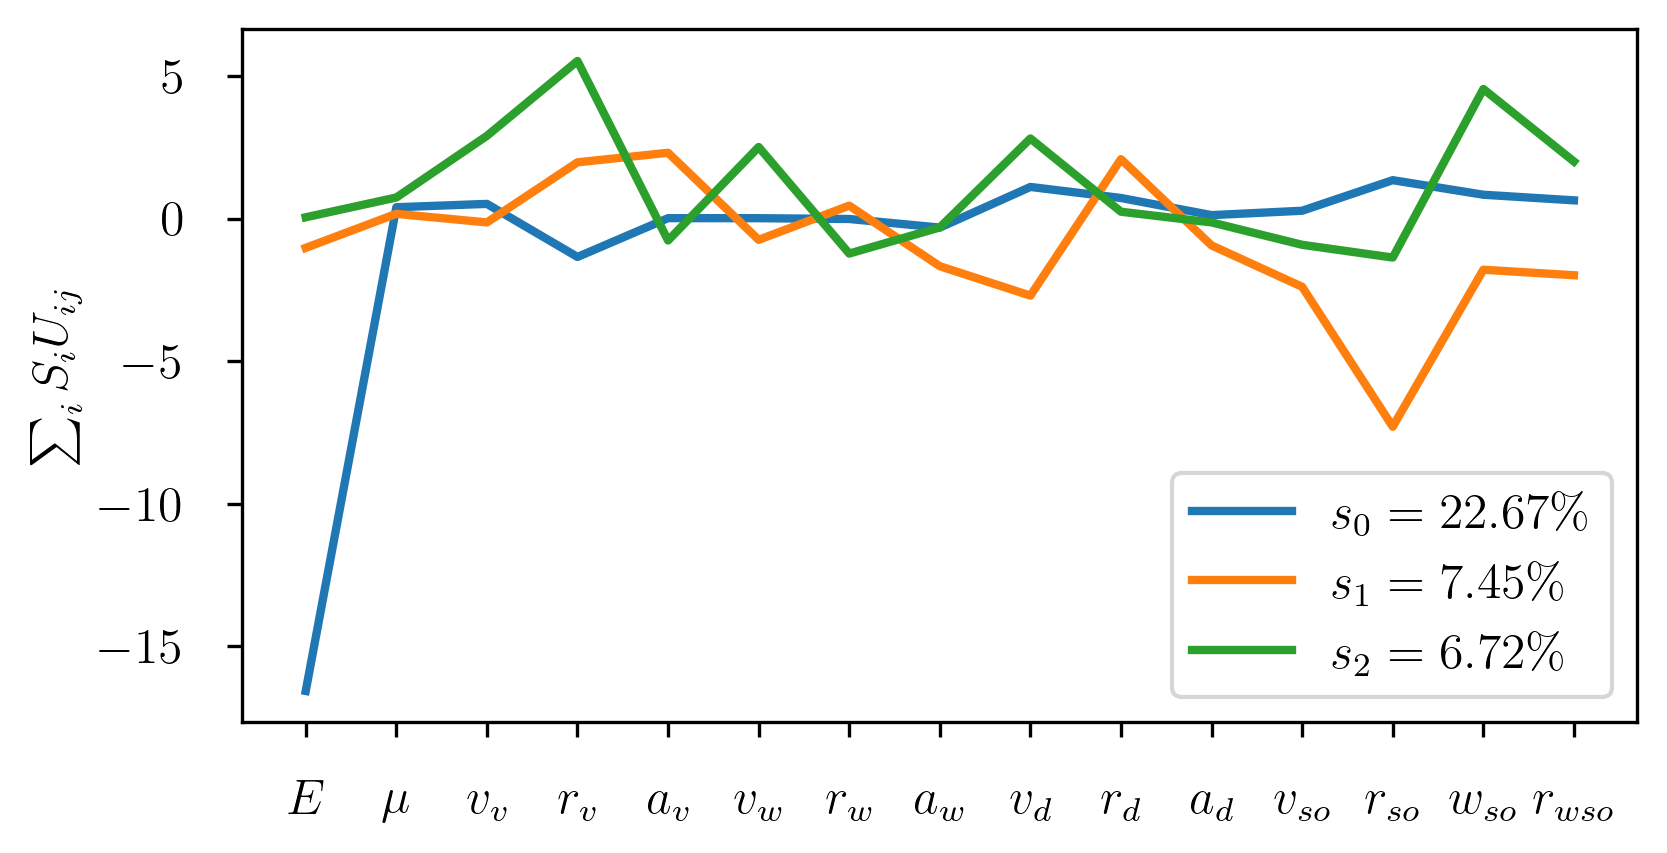

In [15]:
# vectors in param space with largest variance of gradient wrt smatrix training set
f, ax = plt.subplots(facecolor="white", figsize=(6,3), dpi=300)
for i in range(3):
    s = asq.S[i] ** 2 / np.sum(asq.S**2) * 100
    plt.plot(list(range(15)), asq.Utrans[:,i], label=f"$s_{i} = {s:.2f}\%$")
ax.xaxis.set_ticks(list(range(15)))
ax.xaxis.set_ticklabels(param_labels[unfrozen_mask])
#plt.ylim([-1.0, 1.0])
plt.ylabel(r"$ \sum_i S_{i} U_{ij} $")
plt.legend()
plt.savefig("active_subspace_vectors.pdf", bbox_inches="tight")

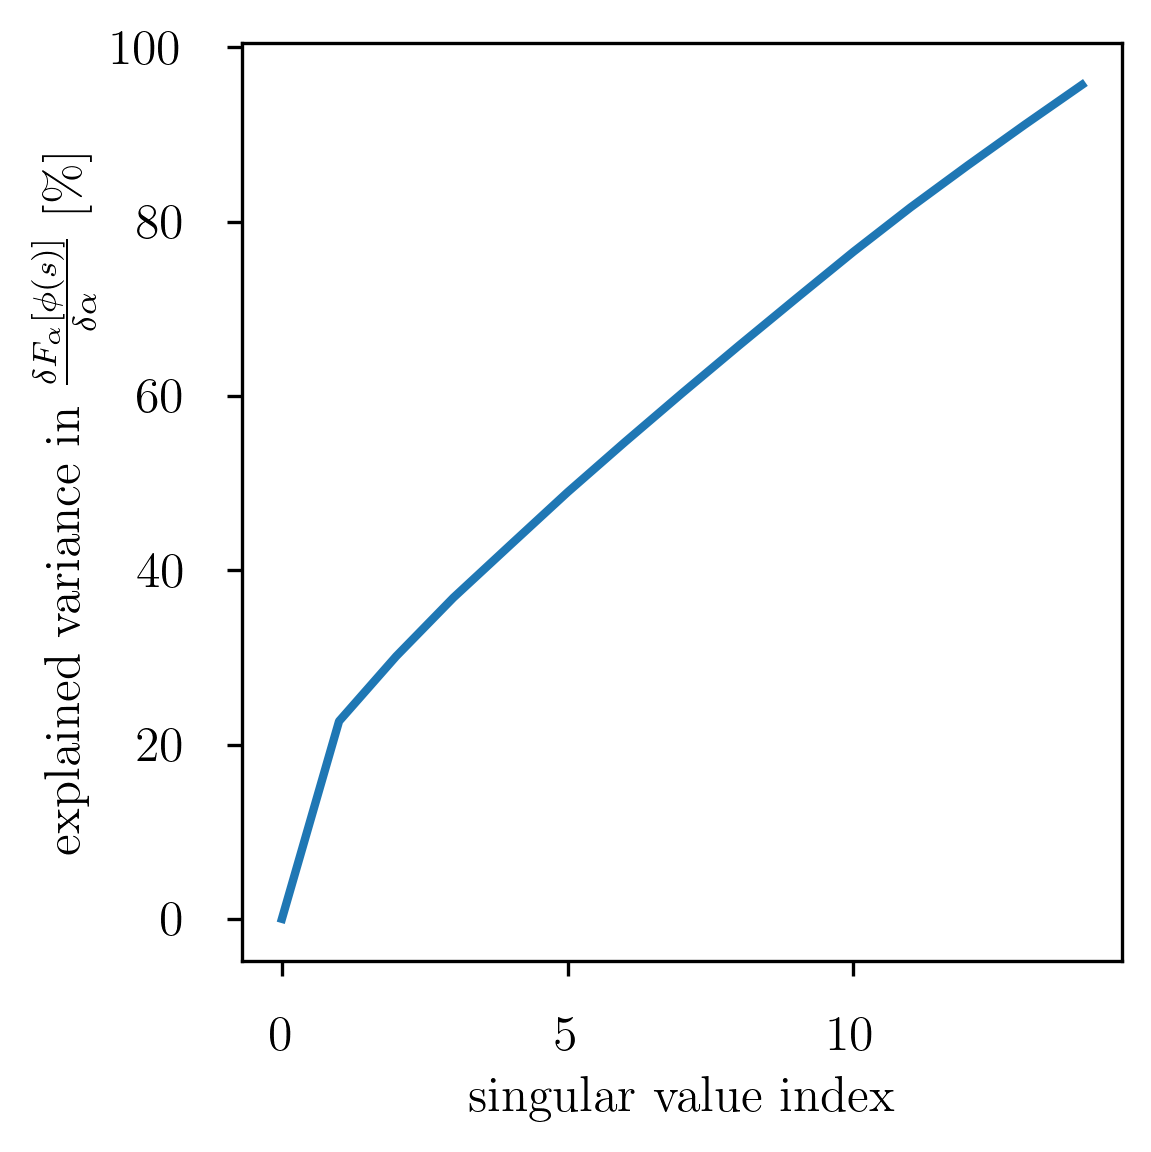

In [16]:
f = plt.figure(facecolor="white", figsize=(4,4), dpi=300)
plt.plot(
    list(range(len(asq.S))), 
    100*np.array([np.sum(asq.S[:i]**2) for i in range(len(asq.S))]) / np.sum(asq.S**2)
)
#plt.ylim([1e-8,100])
plt.xlabel("singular value index")
plt.ylabel(r"explained variance  in $\frac{\delta F_{\alpha}[\phi(s)]}{\delta \alpha}$ [\%]")
plt.tight_layout()
plt.savefig("active_subspace_svs.pdf", bbox_inches="tight")

In [17]:
asq.train_as.shape

(1200, 15)

[8.29236011e-01 1.40725512e-01 1.89121263e-02 7.22138732e-03
 3.60493075e-03 2.29930843e-04 4.07595926e-05 2.11588531e-05
 6.00794667e-06 1.81098923e-06 3.06614924e-07 4.77377511e-08
 7.40785137e-09 2.02163644e-09 1.84300401e-10 6.58692297e-11
 1.39753635e-11 4.25770141e-12 7.25075881e-13 9.97337331e-14
 1.20160659e-14 4.28818630e-15 1.33385953e-15 1.91444283e-16
 4.46104050e-17 9.69513666e-18 1.38535145e-18 4.25089310e-19
 4.74015421e-20 1.18391731e-20]
10


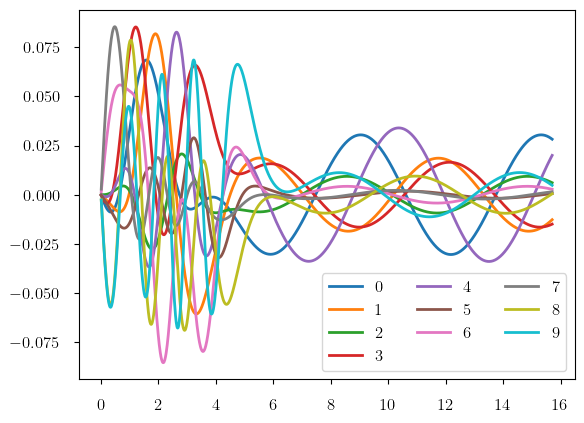

In [18]:
b = asq.emulators[asq.tangent_idxs[0]].rbes[0][0].basis
nb =np.sum(b.singular_values**2/np.sum(b.singular_values**2) > 1e-6) 
print(b.singular_values**2/np.sum(b.singular_values**2))
print(nb)
nb = max(4,nb)
for i in range(nb):
    plt.plot(asq.s_mesh, b.vectors[:,i].real, label=i)
plt.legend(loc="lower right", ncol=3)

In [19]:
test_pt = asq.tangent_points[1]
test_idx = asq.tangent_idxs[1]
exactwf = asq.emulators[test_idx].exact_wave_functions(test_pt)
rbmwf = asq.emulators[test_idx].emulate_wave_functions(test_pt)

for i in range(len(exactwf)):
    for j in range(len(exactwf[i])):
        rbmwf[i][j] *= exactwf[i][j][200] / rbmwf[i][j][200]

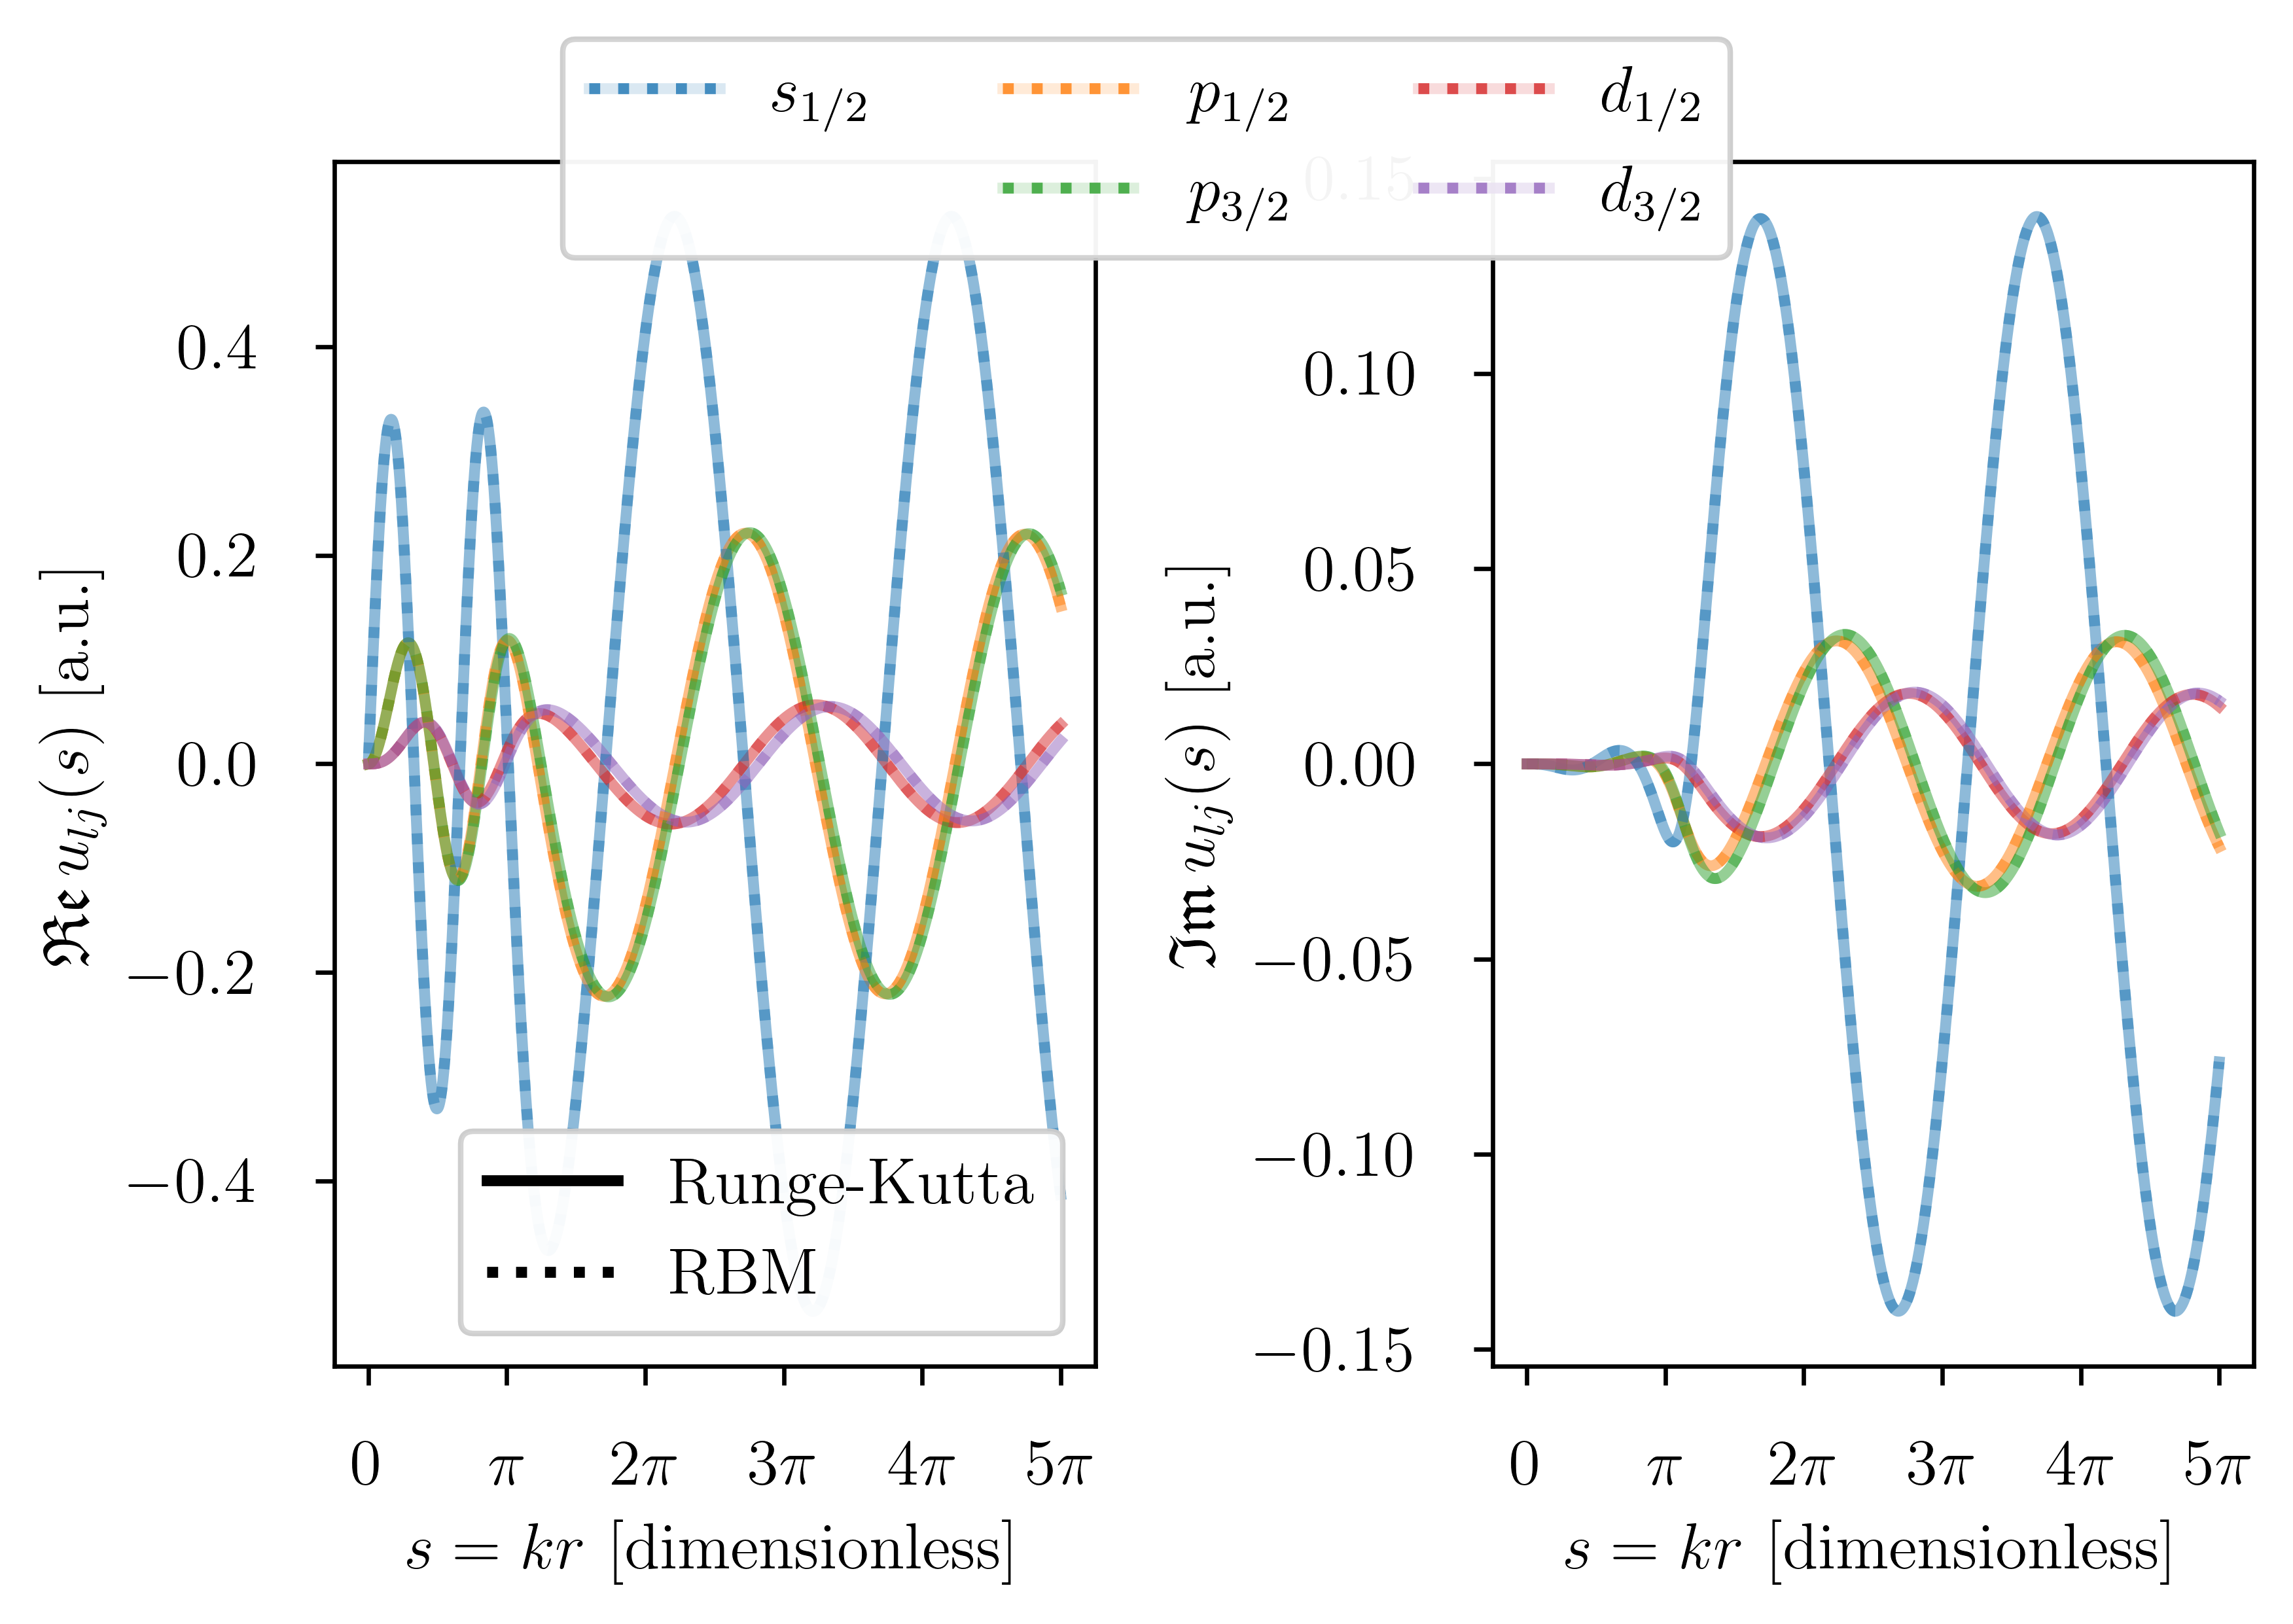

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), dpi=600)
fig.patch.set_facecolor("white")

rose.training.compare_partial_waves(
    s_mesh, [exactwf[:3], rbmwf[:3]], ["Runge-Kutta", "RBM"], fig, ax1, ax2
)
plt.tight_layout()
plt.savefig("RBM_ASQ_global_FF_wavefunctions.pdf", bbox_inches="tight")

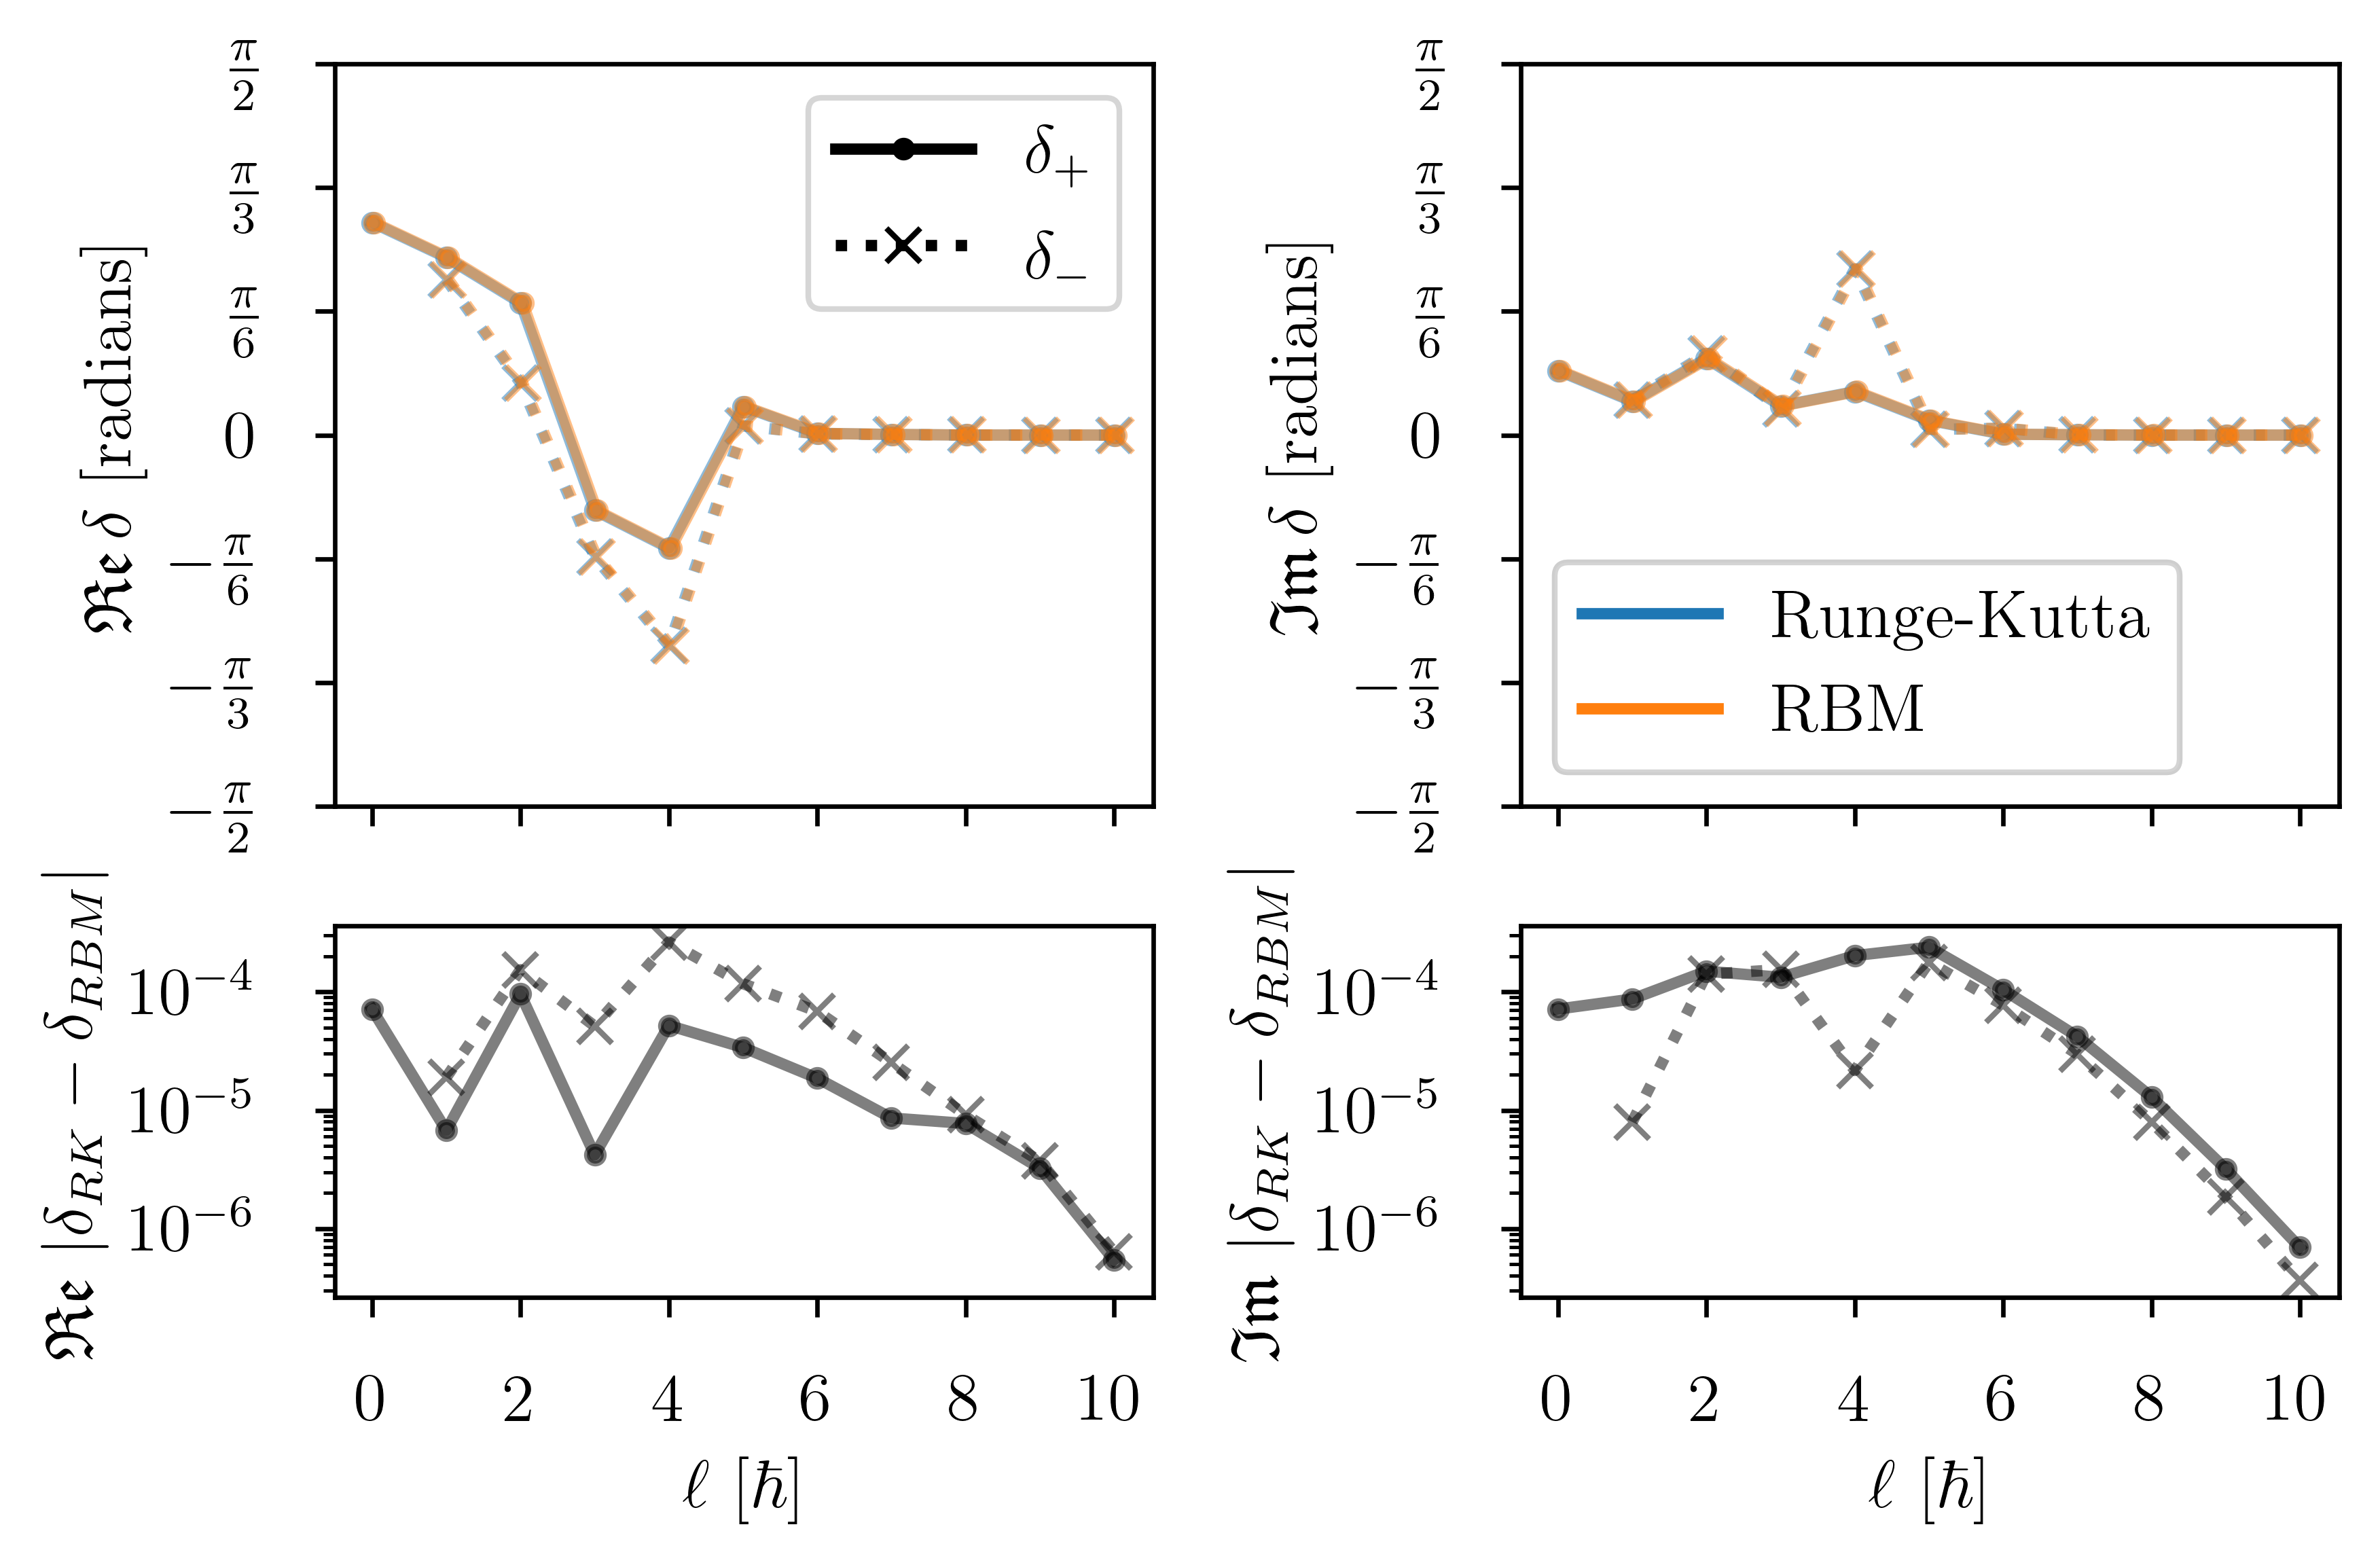

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, sharex=True, figsize=(6, 4), height_ratios=[1, 0.5], dpi=600
)
fig.patch.set_facecolor("white")

exactphase = asq.emulators[test_idx].exact_phase_shifts(test_pt)
rbmphase = asq.emulators[test_idx].emulate_phase_shifts(test_pt)

rose.training.compare_phase_shifts_err(
    exactphase, 
    rbmphase,
    "Runge-Kutta", 
    "RBM",
    fig,
    ax1,
    ax2,
    ax3,
    ax4,
    small_label1="RK",
    small_label2="RBM",
)
ax1.set_ylim([-np.pi / 2, np.pi / 2])
ax2.set_ylim([-np.pi / 2, np.pi / 2])
plt.tight_layout()
plt.savefig("RBM_ASQ_global_FF_phase_shift_errs.pdf", bbox_inches="tight")

In [23]:
test_pts = asq.sample_from_active_neighborhood(asq.tangent_points[0], 60, 600)

/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (


In [24]:
tps = []
for t in test_pts:
    d,idx = asq.active_subspace_kdtree.query(asq.to_AS(t))
    if idx == asq.tangent_idxs[0]:
        tps.append(t)
    
tps = np.array(tps)
print(tps.shape)

(21, 17)


In [25]:
angles = np.linspace(0,np.pi,180)

In [26]:
%%time
exact_dsdo = []
for t in tps:
    exact_dsdo.append(asq.solver.exact_xs(t, angles).dsdo)

/home/beykyle/rose/src/rose/scattering_amplitude_emulator.py:719: RuntimeWarning: invalid value encountered in divide
  rutherford = 10 * self.eta**2 / (4 * k**2 * sin2**2)
/home/beykyle/rose/src/rose/scattering_amplitude_emulator.py:721: RuntimeWarning: invalid value encountered in divide
  -self.eta
/home/beykyle/rose/src/rose/scattering_amplitude_emulator.py:723: RuntimeWarning: divide by zero encountered in log
  * np.exp(-1j * self.eta * np.log(sin2) + 2j * self.sigma_l[0])
/home/beykyle/rose/src/rose/scattering_amplitude_emulator.py:723: RuntimeWarning: invalid value encountered in multiply
  * np.exp(-1j * self.eta * np.log(sin2) + 2j * self.sigma_l[0])
/home/beykyle/rose/src/rose/scattering_amplitude_emulator.py:719: RuntimeWarning: invalid value encountered in divide
  rutherford = 10 * self.eta**2 / (4 * k**2 * sin2**2)
/home/beykyle/rose/src/rose/scattering_amplitude_emulator.py:721: RuntimeWarning: invalid value encountered in divide
  -self.eta
/home/beykyle/rose/src/rose/

CPU times: user 12.7 s, sys: 6.72 ms, total: 12.8 s
Wall time: 12.8 s


In [27]:
%%time
rbm_dsdo = []
for t in tps:
    rbm_dsdo.append(asq.emulators[asq.tangent_idxs[0]].emulate_xs(t, angles).dsdo)

CPU times: user 163 ms, sys: 145 ms, total: 308 ms
Wall time: 51.6 ms


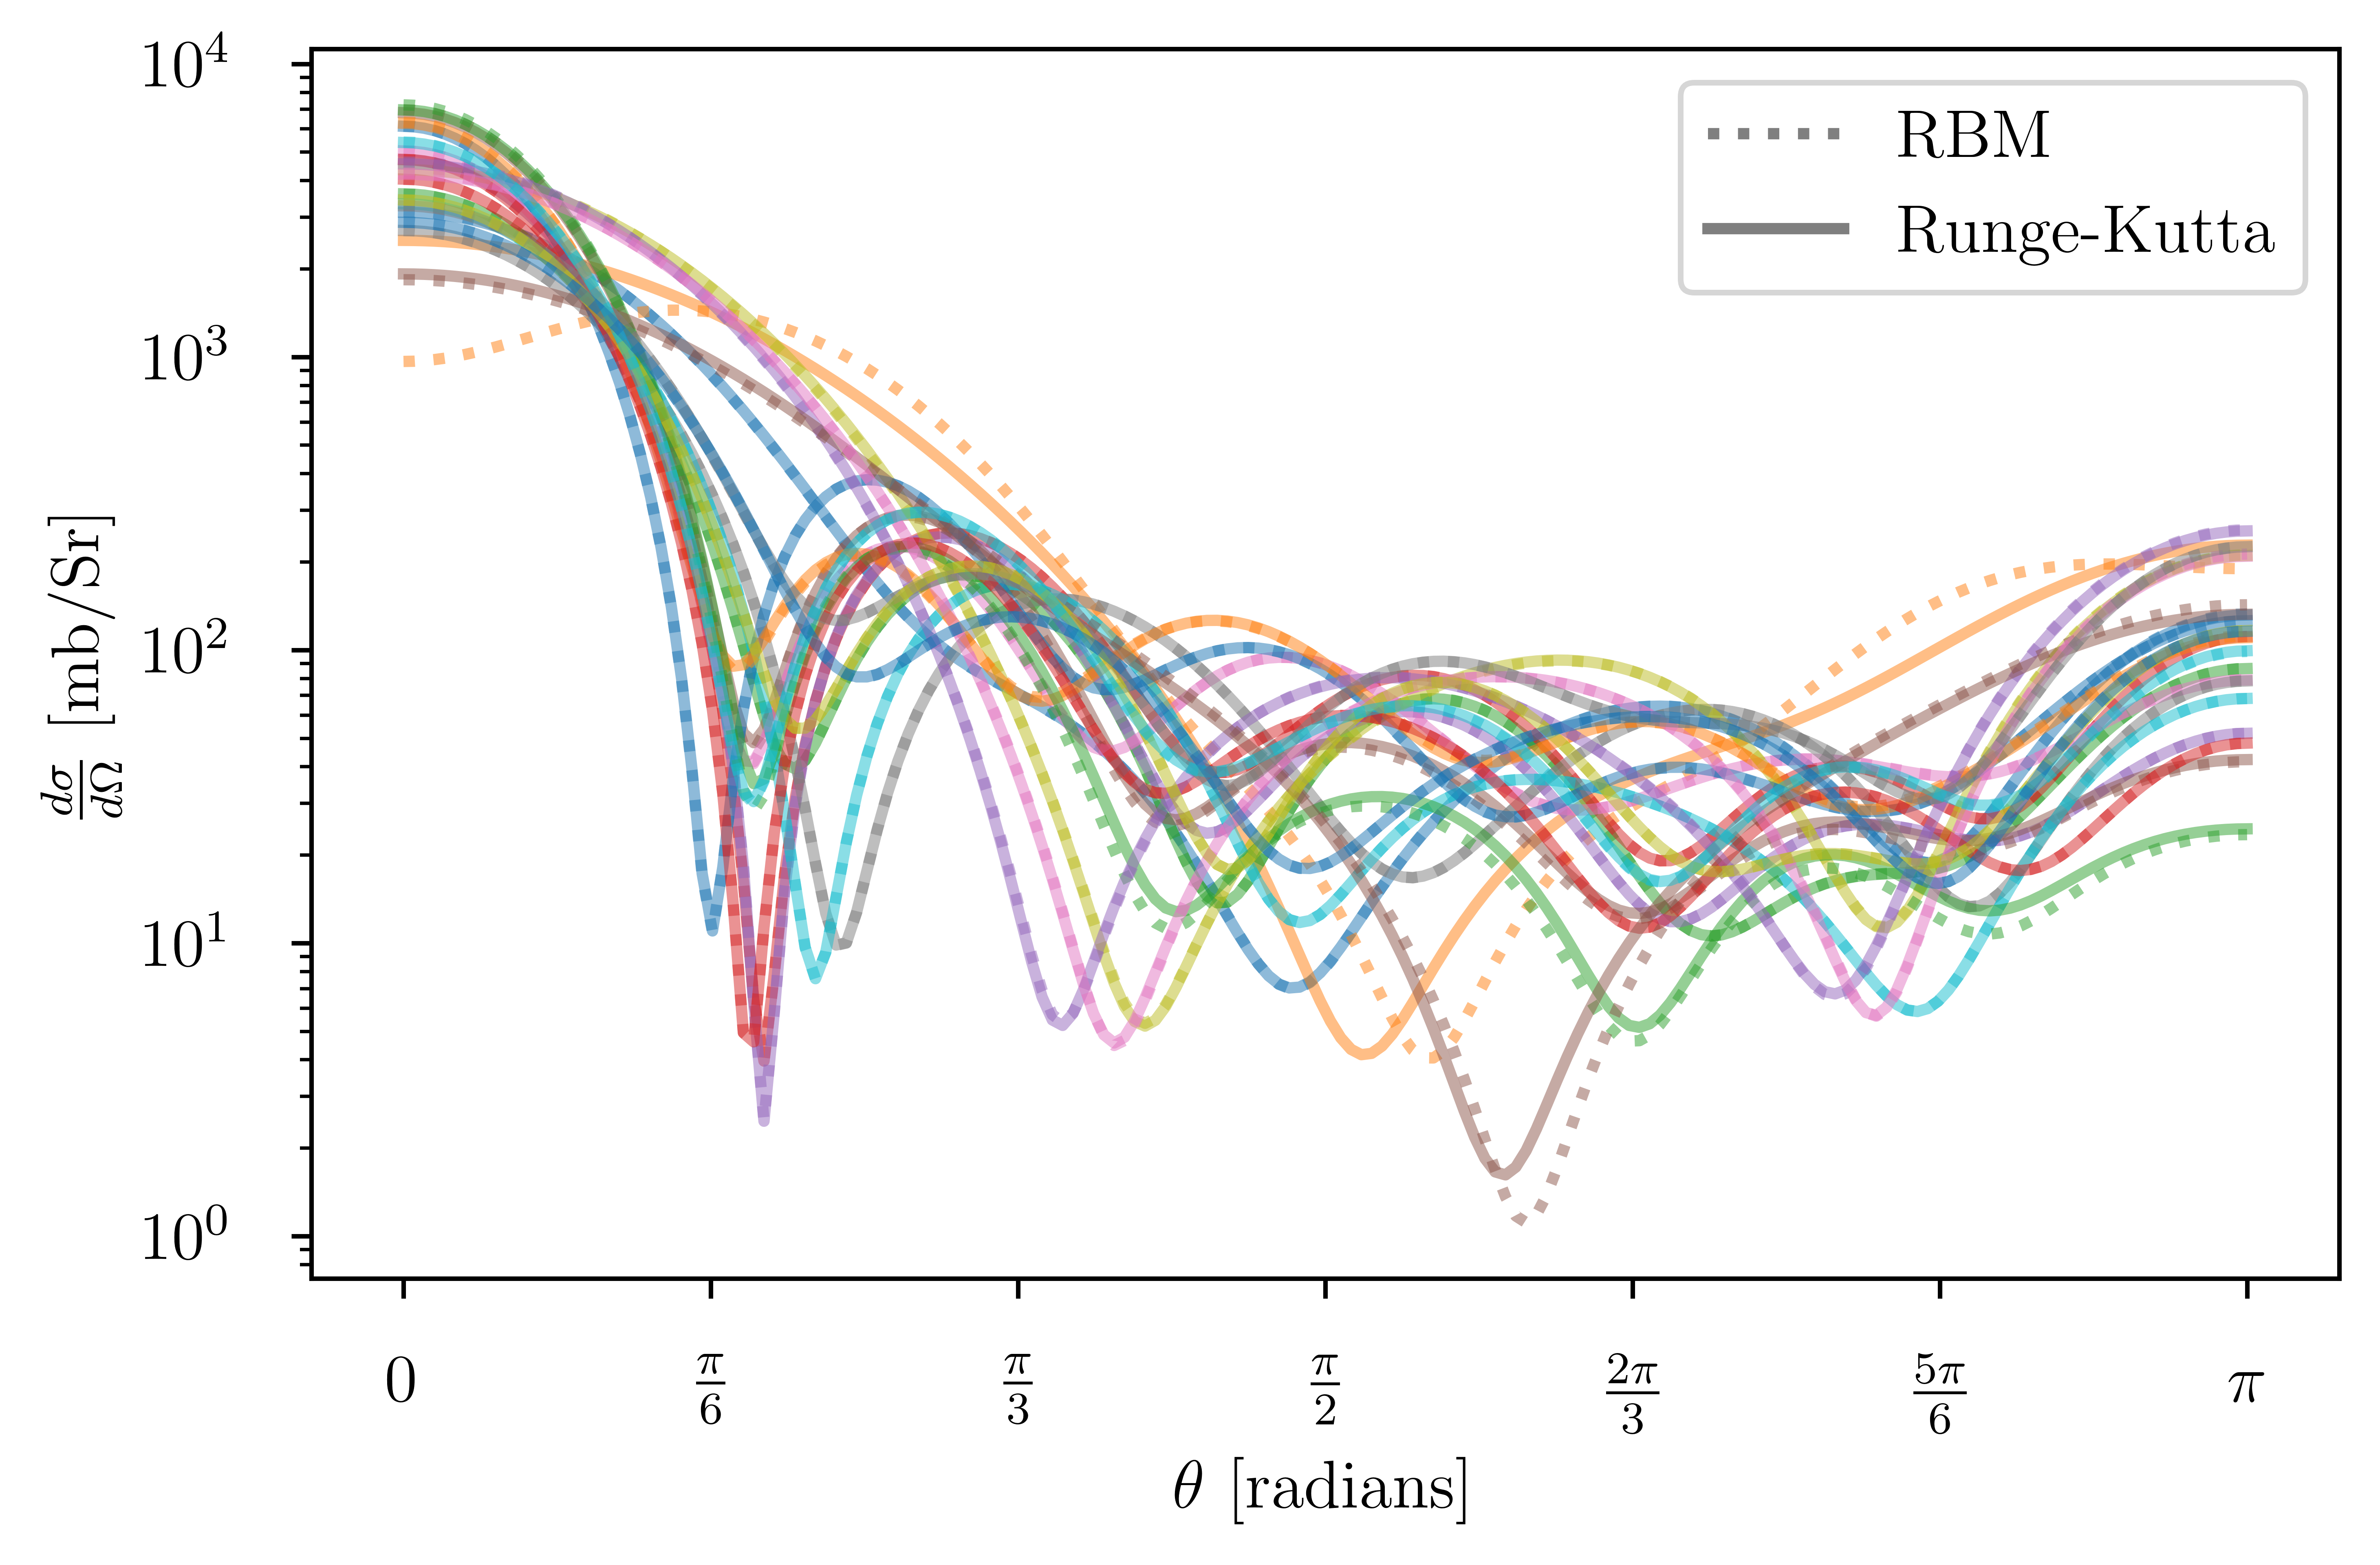

In [28]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=1000)
fig.patch.set_facecolor("white")
legend_styles = []
for i in range(len(tps)):
    x = angles 
    
    # HIFI
    y_exact = exact_dsdo[i]

    # emulated
    y_emu = rbm_dsdo[i]

    (p,) = ax.plot(x, y_emu, ":", alpha=0.5)
    ax.plot(x, y_exact, color=p.get_color(), alpha=0.5)
    legend_styles.append(p)

legend_styles = [
    Line2D([0], [0], color="k", linestyle=":", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["RBM", "Runge-Kutta"])
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=6)))

plt.xlabel(r"$\theta$ [radians]", fontsize=12)
plt.ylabel(r"$\frac{d\sigma}{d\Omega}$ [mb/Sr]", fontsize=12)
plt.yscale("log")
plt.tight_layout()
plt.savefig("RBM_ASQ_global_FF_dsdo.pdf", bbox_inches="tight")

In [29]:
asq.emulators[asq.tangent_idxs[0]].rbes[0][0].basis.solver.interaction.training_info.shape

(17, 2)

In [30]:
asq.emulators[asq.tangent_idxs[0]].rbes[0][0].basis.solver.interaction.n_basis

15

In [31]:
def emulate_xs(sample):
    return asq.get_local_emulator(sample).emulate_xs(sample)

In [32]:
A, Z, El = (137, 56, "Ba")
egrid = cgmf_ebin
omp = rose.koning_delaroche.KDGlobal(rose.Projectile.neutron)

In [33]:
%%time
xs_rxn_emu = np.zeros_like(egrid)
xs_t_emu = np.zeros_like(egrid)
for i,e in enumerate(egrid):
    (mu, E_com, _, _, _), params = omp.get_params(A, Z, E_com=e)
    xs_emu = emulate_xs(np.array([E_com, mu, *params]))
    xs_rxn_emu[i] = xs_emu.rxn
    xs_t_emu[i] = xs_emu.t

/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (
/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (
/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (
/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (
/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (
/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_tra

CPU times: user 15.8 s, sys: 17.1 s, total: 32.9 s
Wall time: 4.63 s


/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (


In [34]:
%%time
xs_rxn = np.zeros_like(egrid)
xs_t = np.zeros_like(egrid)
alphas = []
for i,e in tqdm(enumerate(egrid), total=egrid.size):
    (mu, E_com, _, _, _), params = omp.get_params(A, Z, E_com=e)
    alphas.append( np.array((E_com, mu, *params)) )
    xs = sae.exact_xs(alphas[i])
    xs_rxn[i] = xs.rxn
    xs_t[i] = xs.t

100%|██████████| 200/200 [01:54<00:00,  1.74it/s]

CPU times: user 1min 54s, sys: 578 ms, total: 1min 54s
Wall time: 1min 54s


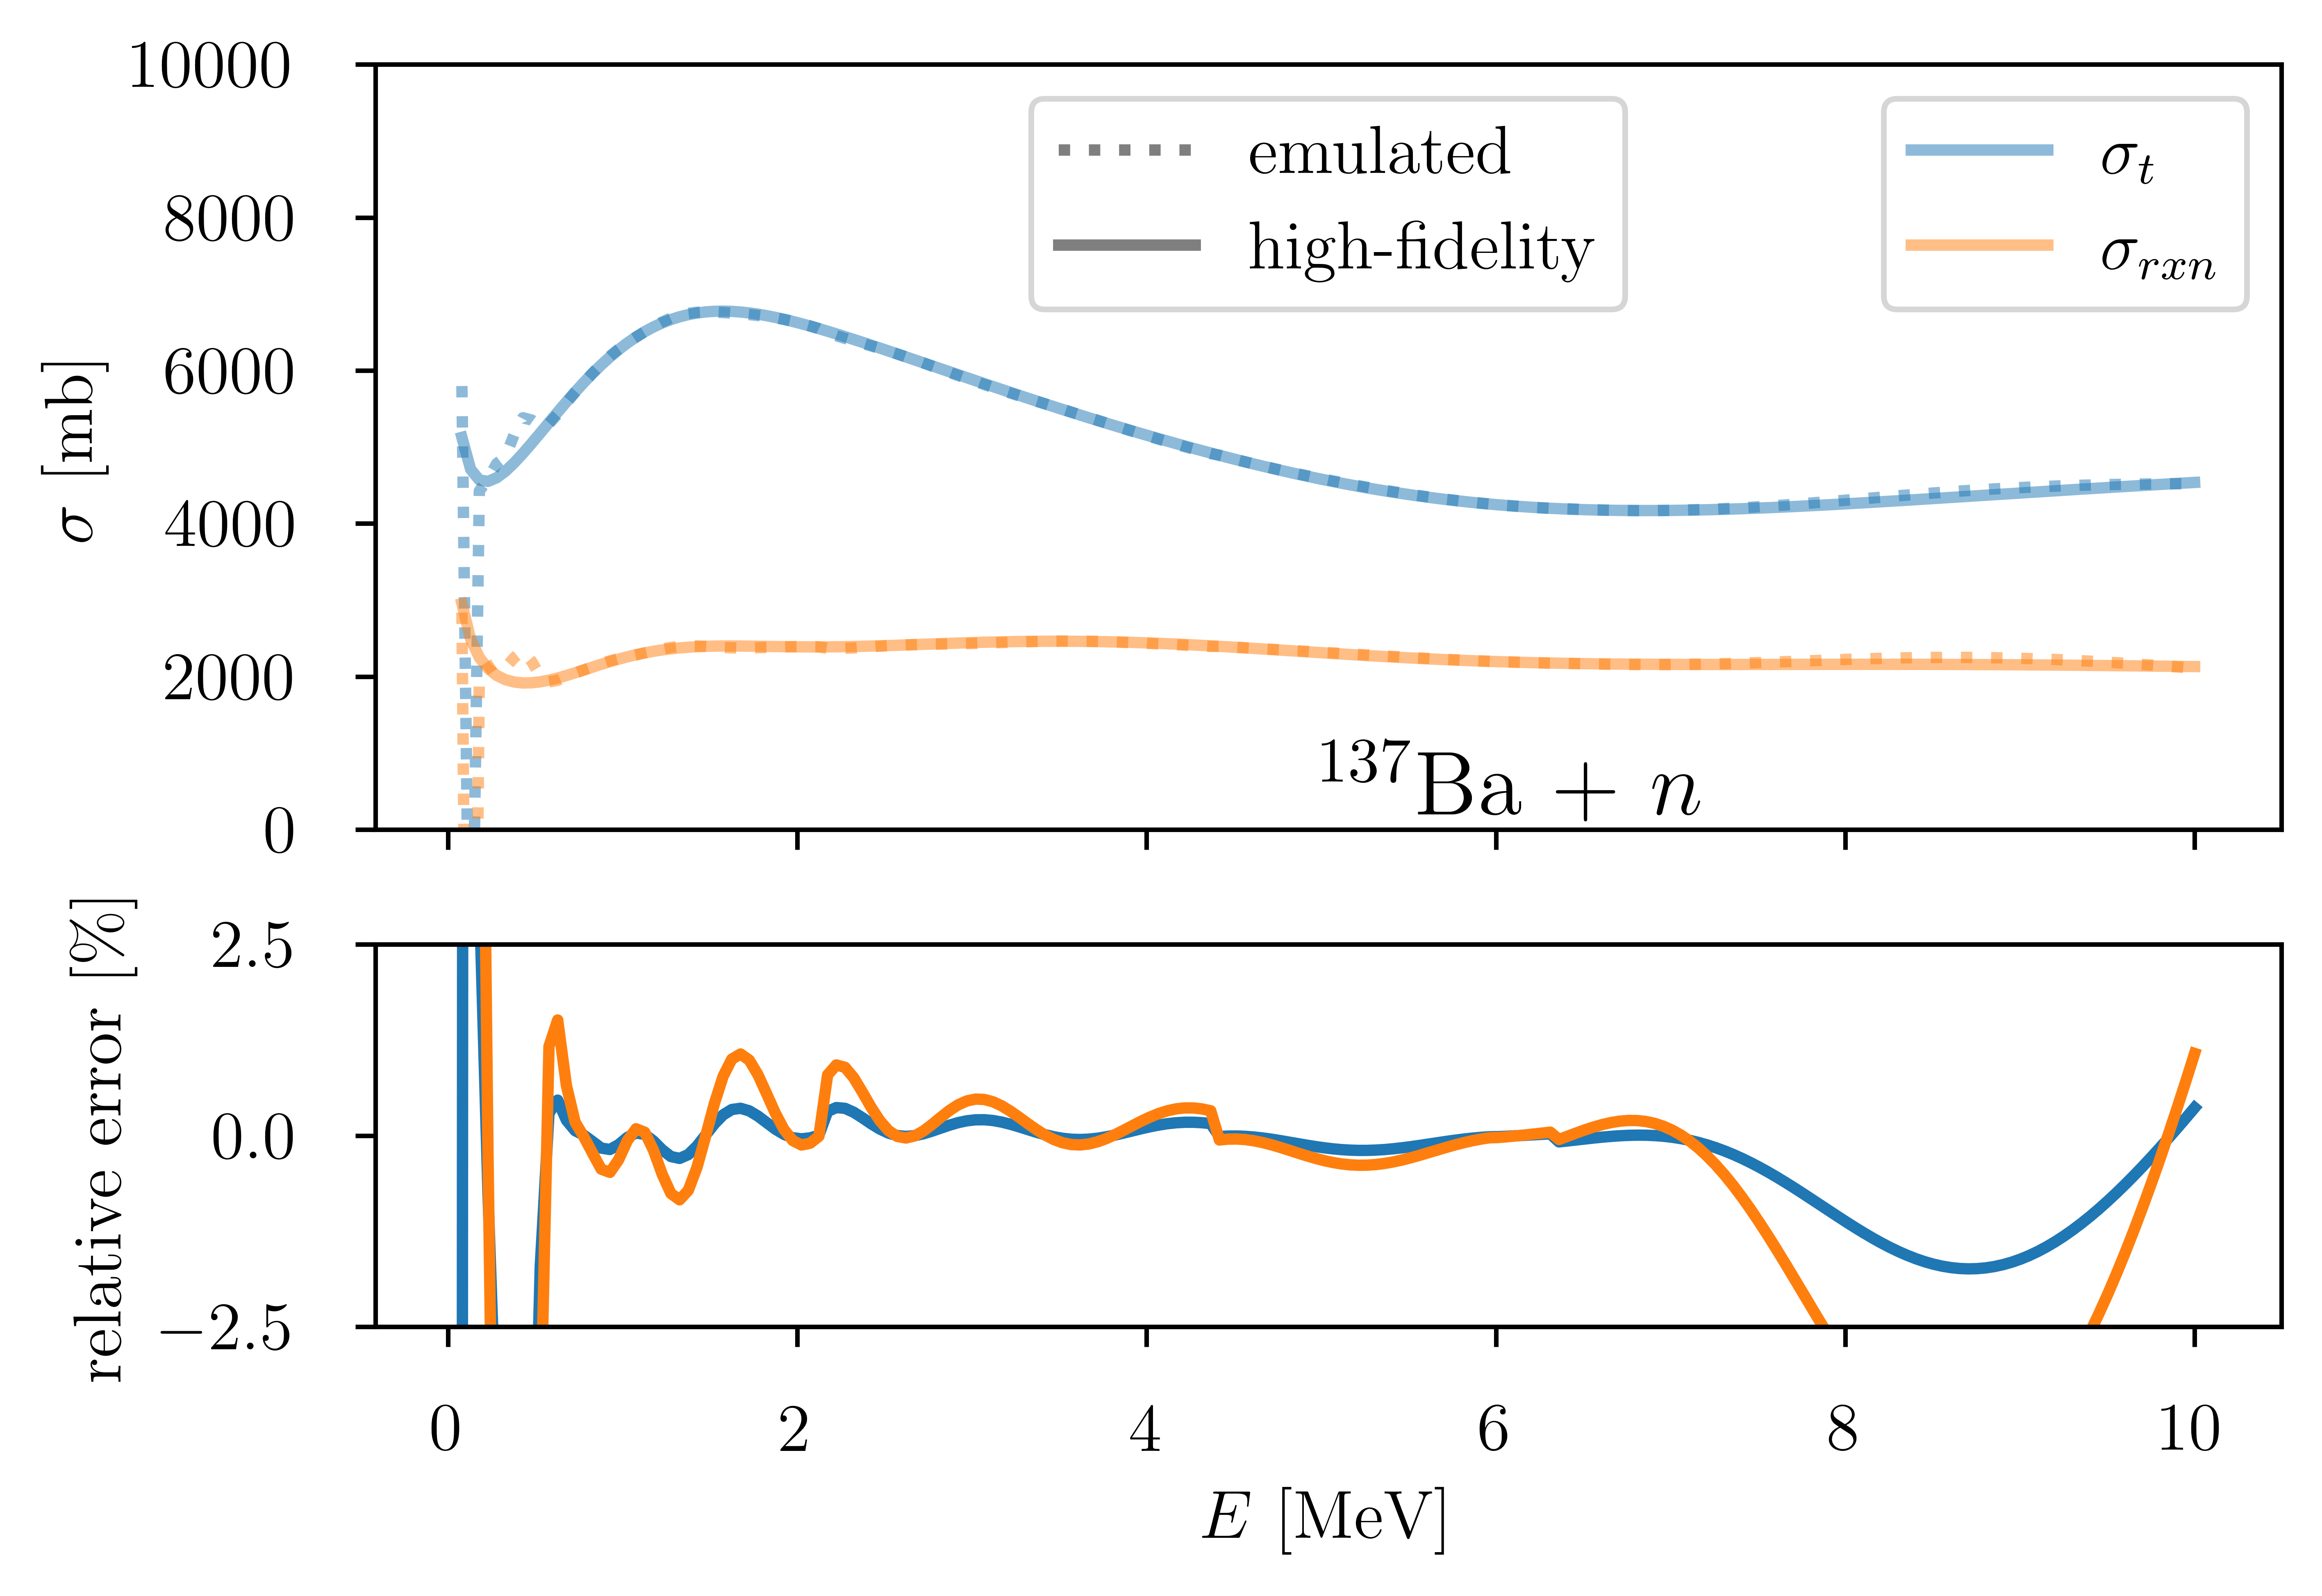

In [35]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=[1, 0.5], figsize=(6, 4), dpi=1000)
fig.patch.set_facecolor("white")

pt = ax1.plot(egrid, xs_t_emu, ":", alpha=0.5)
ax1.plot(egrid, xs_t, color=pt[0].get_color(), alpha=0.5)

prxn = ax1.plot(egrid, xs_rxn_emu, ":", alpha=0.5)
ax1.plot(egrid, xs_rxn, color=prxn[0].get_color(), alpha=0.5)

xs_styles = [
    Line2D([0], [0], color=pt[0].get_color(),  alpha=0.5),
    Line2D([0], [0], color=prxn[0].get_color(), alpha=0.5),
]

legend_styles = [
    Line2D([0], [0], color="k", linestyle=":",alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
leg2 = ax1.legend(legend_styles, [r"emulated", r"high-fidelity"], loc="upper center")
ax1.add_artist(leg2)
ax1.legend(xs_styles, [r"$\sigma_t$", r"$\sigma_{rxn}$"], loc="upper right")
ax1.set_ylim([0,1e4])
ax1.text(5, 200, r"$^{137}$Ba + $n$", fontsize=16)
plt.xlabel(r"$E$ [MeV]", fontsize=12)
ax1.set_ylabel(r"$\sigma$ [mb]", fontsize=12)
#ax1.set_yscale("log")
ax2.plot( egrid, 100*(xs_t - xs_t_emu)/xs_t , color=pt[0].get_color() )
ax2.plot( egrid, 100*(xs_rxn - xs_rxn_emu)/xs_rxn , color=prxn[0].get_color() )

ax2.set_ylabel(r"relative error [\%]")
ax2.set_ylim([-2.5,2.5])
plt.savefig("sigma_rxn_asq_err_iter1.pdf", bbox_inches="tight")

In [36]:
rel_diff = (xs_rxn - xs_rxn_emu)/xs_rxn

In [37]:
bad_tan_idxs = []
dists = []
samples = []
for i,e in tqdm(enumerate(egrid), total=egrid.size):
    (mu, E_com, _, _, _), params = omp.get_params(A, Z, E_com=e)
    sample = np.array([E_com, mu, *params])
    dist, idx, _ = asq.get_tangent_space(sample)
    bad_tan_idxs.append(asq.tangent_idxs[idx])
    dists.append(dist)
    samples.append(sample)


  0%|          | 0/200 [00:00<?, ?it/s]/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (
/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (
/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (
/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (
/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (
  2%|▎         | 5/200 [00:00<00:04, 44.85it/s]/home/beykyle/rose/src/rose/active_subspace.py:45

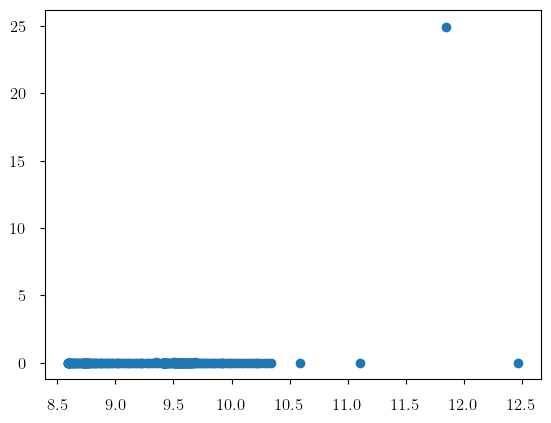

In [38]:
plt.scatter(dists, rel_diff**2)

In [39]:
bad_tan_idxs = list(set(bad_tan_idxs))
bad_tan_idxs

[1121, 35, 135, 720, 598, 349]

In [40]:
new_training_pts = []
for idx in bad_tan_idxs:
    new_training_pts.append( 
        asq.sample_from_active_neighborhood( asq.train[idx,:], 50, 50 )
    )


/home/beykyle/rose/src/rose/active_subspace.py:455: RuntimeWarning: divide by zero encountered in divide
  x = (self.forward_pspace_transform(sample) - self.train_mean) / (


In [41]:
train2 = np.concatenate( new_training_pts, axis=0)

In [42]:
#train2 = asq.sample_active(200, seed=137)

In [43]:
asq.update_train(train2, None)

Calculating interaction terms at 300 samples...
Calculating training wavefunctions at 300 samples...


100%|██████████| 300/300 [03:14<00:00,  1.54it/s]


Discovering active subspace from 1500 samples...


/home/beykyle/rose/src/rose/active_subspace.py:390: RuntimeWarning: invalid value encountered in divide
  np.trapz(
/home/beykyle/rose/src/rose/active_subspace.py:403: RuntimeWarning: invalid value encountered in divide
  np.trapz(


In [44]:
asq.neighborhood_size = 45
asq.tangent_fraction = 0.15

In [45]:
# sample 
asq.update_tangents(min_bases_eim=5)

Constructing RBMs from neighborhoods around 226 sampled tangent points...
226 tangent points chosen using weighted method. Building neighborhoods...


  0%|          | 0/226 [00:00<?, ?it/s]/home/beykyle/rose/src/rose/scattering_amplitude_emulator.py:354: RuntimeWarning: invalid value encountered in divide
  self.rutherford = 0.0 / (np.sin(self.angles / 2) ** 4)
 83%|████████▎ | 188/226 [15:48<03:11,  5.04s/it]


LinAlgError: Singular matrix

In [ ]:
%%time
xs_rxn_emu = np.zeros_like(egrid)
xs_t_emu = np.zeros_like(egrid)
for i,e in enumerate(egrid):
    (mu, E_com, _, _, _), params = omp.get_params(A, Z, E_com=e)
    xs_emu = emulate_xs(np.array([E_com, mu, *params]))
    xs_rxn_emu[i] = xs_emu.rxn
    xs_t_emu[i] = xs_emu.t

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=[1, 0.5], figsize=(6, 4), dpi=1000)
fig.patch.set_facecolor("white")

pt = ax1.plot(egrid, xs_t_emu, ":", alpha=0.5)
ax1.plot(egrid, xs_t, color=pt[0].get_color(), alpha=0.5)

prxn = ax1.plot(egrid, xs_rxn_emu, ":", alpha=0.5)
ax1.plot(egrid, xs_rxn, color=prxn[0].get_color(), alpha=0.5)

xs_styles = [
    Line2D([0], [0], color=pt[0].get_color(),  alpha=0.5),
    Line2D([0], [0], color=prxn[0].get_color(), alpha=0.5),
]

legend_styles = [
    Line2D([0], [0], color="k", linestyle=":",alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
leg2 = ax1.legend(legend_styles, [r"emulated", r"high-fidelity"], loc="upper center")
ax1.add_artist(leg2)
ax1.legend(xs_styles, [r"$\sigma_t$", r"$\sigma_{rxn}$"], loc="upper right")
ax1.set_ylim([0,1e4])
ax1.text(5, 200, r"$^{137}$Ba + $n$", fontsize=16)
plt.xlabel(r"$E$ [MeV]", fontsize=12)
ax1.set_ylabel(r"$\sigma$ [mb]", fontsize=12)
#ax1.set_yscale("log")
ax2.plot( egrid, 100*(xs_t - xs_t_emu)/xs_t , color=pt[0].get_color() )
ax2.plot( egrid, 100*(xs_rxn - xs_rxn_emu)/xs_rxn , color=prxn[0].get_color() )

ax2.set_ylabel(r"relative error [\%]")
ax2.set_ylim([-2.5,2.5])
plt.savefig("sigma_rxn_asq_err_iter2.pdf")

In [ ]:
bounds3 = bounds.copy()
bounds3[0,:] = np.array([0.08,1.2])
bounds3

In [ ]:
train3 = asq.sample_active(500, seed=137)

In [ ]:
asq.update_train(train3, None)

In [ ]:
asq.update_tangents()

In [ ]:
%%time
xs_rxn_emu = np.zeros_like(egrid)
xs_t_emu = np.zeros_like(egrid)
for i,e in enumerate(egrid):
    (mu, E_com, _, _, _), params = omp.get_params(A, Z, E_com=e)
    xs_emu = emulate_xs(np.array([E_com, mu, *params]))
    xs_rxn_emu[i] = xs_emu.rxn
    xs_t_emu[i] = xs_emu.t

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=[1, 0.5], figsize=(6, 4), dpi=1000)
fig.patch.set_facecolor("white")

pt = ax1.plot(egrid, xs_t_emu, ":", alpha=0.5)
ax1.plot(egrid, xs_t, color=pt[0].get_color(), alpha=0.5)

prxn = ax1.plot(egrid, xs_rxn_emu, ":", alpha=0.5)
ax1.plot(egrid, xs_rxn, color=prxn[0].get_color(), alpha=0.5)

xs_styles = [
    Line2D([0], [0], color=pt[0].get_color(),  alpha=0.5),
    Line2D([0], [0], color=prxn[0].get_color(), alpha=0.5),
]

legend_styles = [
    Line2D([0], [0], color="k", linestyle=":",alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
leg2 = ax1.legend(legend_styles, [r"emulated", r"high-fidelity"], loc="upper center")
ax1.add_artist(leg2)
ax1.legend(xs_styles, [r"$\sigma_t$", r"$\sigma_{rxn}$"], loc="upper right")
ax1.set_ylim([0,1e4])
ax1.text(5, 200, r"$^{137}$Ba + $n$", fontsize=16)
plt.xlabel(r"$E$ [MeV]", fontsize=12)
ax1.set_ylabel(r"$\sigma$ [mb]", fontsize=12)
#ax1.set_yscale("log")
ax2.plot( egrid, 100*(xs_t - xs_t_emu)/xs_t , color=pt[0].get_color() )
ax2.plot( egrid, 100*(xs_rxn - xs_rxn_emu)/xs_rxn , color=prxn[0].get_color() )

ax2.set_ylabel(r"relative error [\%]")
ax2.set_ylim([-2.5,2.5])
plt.savefig("sigma_rxn_asq_err_iter3.pdf")

In [ ]:
asq.tangent_fraction

In [ ]:
asq.tangent_idxs.shape